In [ ]:
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback

In [ ]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model based on the training reward
    and tracking the actor losses, critic losses, and rewards per episode.

    :param check_freq: Frequency to check and save model.
    :param log_dir: Directory to save the model.
    :param verbose: Verbosity level.
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf
        self.actor_losses = []
        self.critic_losses = []
        self.rewards = []

    def _init_callback(self) -> None:
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                mean_reward = np.mean(y[-100:])
                self.rewards.append(mean_reward)
                if self.verbose >= 1:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

                # New best model
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    if self.verbose >= 1:
                        print(f"Saving new best model to {self.save_path}")
                    self.model.save(self.save_path)

        # Access and log losses from the logger dictionary
        if 'train/actor_loss' in self.logger.name_to_value:
            self.actor_losses.append(self.logger.name_to_value['train/actor_loss'])
        if 'train/critic_loss' in self.logger.name_to_value:
            self.critic_losses.append(self.logger.name_to_value['train/critic_loss'])

        return True


In [ ]:
# Set log directory
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make("LunarLanderContinuous-v2")
env = Monitor(env, log_dir)

# Add action noise for exploration
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Initialize model
model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=0)

# Create callback to save model and track losses
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [ ]:
callback.actor_losses

[]

In [ ]:
# Train the model
timesteps = 1e5
model.learn(total_timesteps=int(timesteps), callback=callback)


Num timesteps: 1000
Best mean reward: -233.71 - Last mean reward per episode: -228.73
Saving new best model to tmp/best_model
Num timesteps: 2000
Best mean reward: -228.73 - Last mean reward per episode: -214.73
Saving new best model to tmp/best_model
Num timesteps: 3000
Best mean reward: -214.73 - Last mean reward per episode: -211.31
Saving new best model to tmp/best_model
Num timesteps: 4000
Best mean reward: -211.31 - Last mean reward per episode: -208.53
Saving new best model to tmp/best_model
Num timesteps: 5000
Best mean reward: -208.53 - Last mean reward per episode: -202.85
Saving new best model to tmp/best_model
Num timesteps: 6000
Best mean reward: -202.85 - Last mean reward per episode: -203.64
Num timesteps: 7000
Best mean reward: -202.85 - Last mean reward per episode: -202.04
Saving new best model to tmp/best_model
Num timesteps: 8000
Best mean reward: -202.04 - Last mean reward per episode: -186.42
Saving new best model to tmp/best_model
Num timesteps: 9000
Best mean re

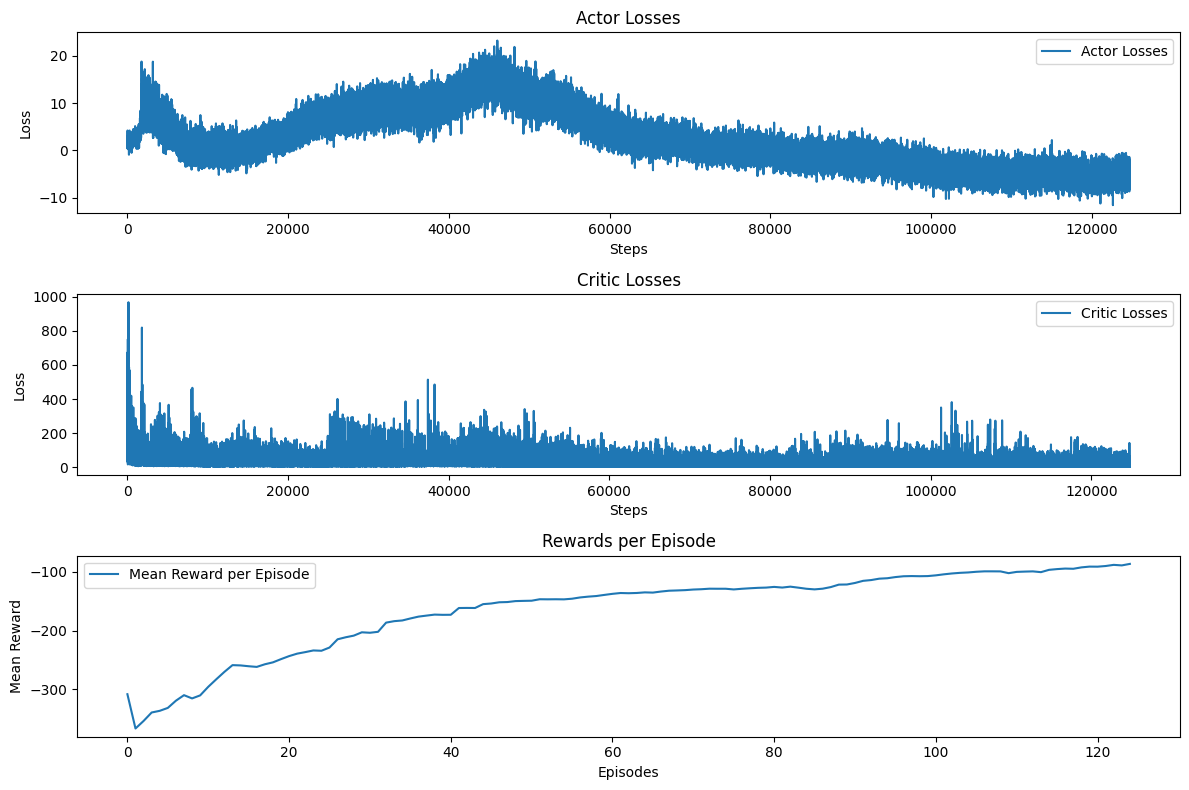

In [ ]:
# Plot learning curves
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(callback.actor_losses, label="Actor Losses")
plt.title("Actor Losses")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(callback.critic_losses, label="Critic Losses")
plt.title("Critic Losses")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(callback.rewards, label="Mean Reward per Episode")
plt.title("Rewards per Episode")
plt.xlabel("Episodes")
plt.ylabel("Mean Reward")
plt.legend()

plt.tight_layout()
plt.show()

# Récupérer les Hyper parametres

# AVEC NOS HYPERPARAMETERS DE BASE

In [ ]:
# Hyperparamètres principaux ajustés pour LunarLanderContinuous-v2
BATCH_SIZE = 128  # Augmenter la taille du batch pour plus de stabilité
TAU_TARGET = 0.005  # Mise à jour douce des cibles pour une meilleure stabilité
DISCOUNT_FACTOR = 0.99  # Horizon temporel plus long pour l'environnement LunarLander
LEARNING_RATE_ACTOR = 1e-3
LEARNING_RATE_CRITIC = 1e-3
ACTOR_HIDDEN_SIZE = [400, 300]  # Taille des couches cachées de l'acteur
CRITIC_HIDDEN_SIZE = [400, 300]  # Taille des couches cachées des critiques
ACTION_NOISE = 0.1  # Conserver le bruit d'action pour favoriser l'exploration
MAX_GRAD_NORM = 0.5
LEARNING_STARTS = 100  # Commencer l'apprentissage après 100 pas
BUFFER_SIZE = int(1e6)  # Augmenter la taille du replay buffer à 1 million pour LunarLander
N_STEPS = 100  # Nombre de pas avant mise à jour
NB_EVALS = 10  # Nombre d'évaluations

In [ ]:
# Set log directory
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make("LunarLanderContinuous-v2")
env = Monitor(env, log_dir)

# Add action noise for exploration
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Initialize model
#model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=0)

# Initialize model
model = TD3(
    "MlpPolicy",
    env,
    action_noise=action_noise,
    buffer_size=BUFFER_SIZE,
    batch_size=BATCH_SIZE,
    tau=TAU_TARGET,
    gamma=DISCOUNT_FACTOR,
    learning_rate=LEARNING_RATE_ACTOR,  # Taux d'apprentissage de l'acteur utilisé ici
    learning_starts=LEARNING_STARTS,
    policy_kwargs={
        "net_arch": {
            "pi": ACTOR_HIDDEN_SIZE,
            "qf": CRITIC_HIDDEN_SIZE,
        },
    },
    verbose=0
)

# Create callback to save model and track losses
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)


In [ ]:
# Set log directory
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make("LunarLanderContinuous-v2")
env = Monitor(env, log_dir)

# Add action noise for exploration
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Initialize model
model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=0)

# Create callback to save model and track losses
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

In [ ]:
# Train the model
timesteps = 1e5
model.learn(total_timesteps=int(timesteps), callback=callback)


Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: -734.02
Saving new best model to tmp/best_model
Num timesteps: 2000
Best mean reward: -734.02 - Last mean reward per episode: -719.80
Saving new best model to tmp/best_model
Num timesteps: 3000
Best mean reward: -719.80 - Last mean reward per episode: -574.63
Saving new best model to tmp/best_model
Num timesteps: 4000
Best mean reward: -574.63 - Last mean reward per episode: -478.40
Saving new best model to tmp/best_model
Num timesteps: 5000
Best mean reward: -478.40 - Last mean reward per episode: -445.31
Saving new best model to tmp/best_model
Num timesteps: 6000
Best mean reward: -445.31 - Last mean reward per episode: -441.15
Saving new best model to tmp/best_model
Num timesteps: 7000
Best mean reward: -441.15 - Last mean reward per episode: -411.40
Saving new best model to tmp/best_model
Num timesteps: 8000
Best mean reward: -411.40 - Last mean reward per episode: -404.40
Saving new best model to tmp/best_m

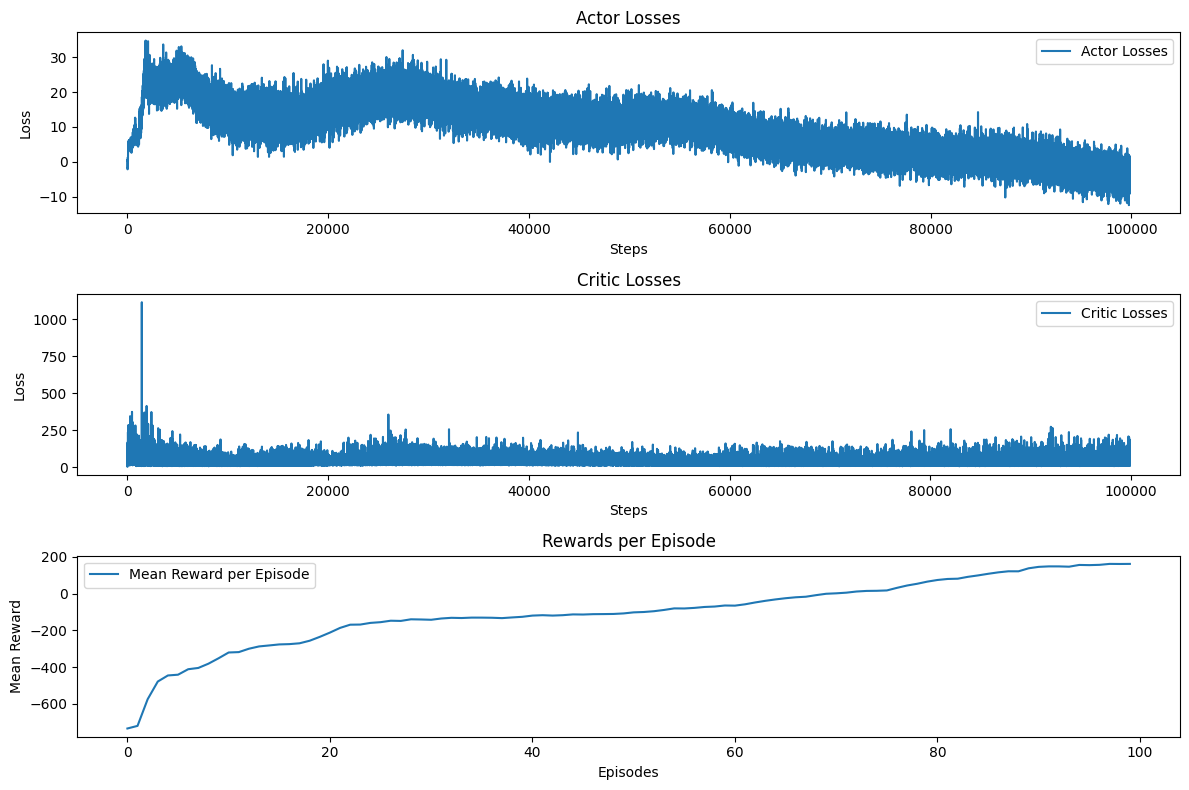

In [ ]:
# Plot learning curves
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(callback.actor_losses, label="Actor Losses")
plt.title("Actor Losses")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(callback.critic_losses, label="Critic Losses")
plt.title("Critic Losses")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(callback.rewards, label="Mean Reward per Episode")
plt.title("Rewards per Episode")
plt.xlabel("Episodes")
plt.ylabel("Mean Reward")
plt.legend()

plt.tight_layout()
plt.show()